In [ ]:

# # IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# # TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# # THEN FEEL FREE TO DELETE THIS CELL.
# # NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# # ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# # NOTEBOOK.

# import os
# import sys
# from tempfile import NamedTemporaryFile
# from urllib.request import urlopen
# from urllib.parse import unquote, urlparse
# from urllib.error import HTTPError
# from zipfile import ZipFile
# import tarfile
# import shutil

# CHUNK_SIZE = 40960
# DATA_SOURCE_MAPPING = 'iam-handwriting-word-database:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1347338%2F2243895%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240708%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240708T012609Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3693004269cfda6d63be844aeb8734916bef4e940cf3cc38023d7232b728a89495933d3d23e4acbac10cbbe1d941e3a81a8b9104a5720c9a773205d9e333e8c0e7eba3a2789b46f0eefcc7cbe20c3079cf2fb120487384d6a2c9bef5de76ce8bf52efd6cfeef2dcc6a1af81b9406ce487ab4dcff8c6025315fedb9f267c7a4d7c04ab92d8bc0376fc553bb571b966086ecc89c9cf8268c9625882f3a1488d6e34fee79419bf51593dfbef61f7ea23be52565cefc915275bd98ba3631a38d7912ee45c49f2a7a5cf4e0a42ec1ed3c83aa7152ff3851d6ebfde7b11c95dd7cbbd1b5ab535c4c454fd952ab28af28a8454bbb6df7bce16e46666cbece0885959530'

# KAGGLE_INPUT_PATH='/kaggle/input'
# KAGGLE_WORKING_PATH='/kaggle/working'
# KAGGLE_SYMLINK='kaggle'

# !umount /kaggle/input/ 2> /dev/null
# shutil.rmtree('/kaggle/input', ignore_errors=True)
# os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
# os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

# try:
#   os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
# except FileExistsError:
#   pass
# try:
#   os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
# except FileExistsError:
#   pass

# for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
#     directory, download_url_encoded = data_source_mapping.split(':')
#     download_url = unquote(download_url_encoded)
#     filename = urlparse(download_url).path
#     destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
#     try:
#         with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
#             total_length = fileres.headers['content-length']
#             print(f'Downloading {directory}, {total_length} bytes compressed')
#             dl = 0
#             data = fileres.read(CHUNK_SIZE)
#             while len(data) > 0:
#                 dl += len(data)
#                 tfile.write(data)
#                 done = int(50 * dl / int(total_length))
#                 sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
#                 sys.stdout.flush()
#                 data = fileres.read(CHUNK_SIZE)
#             if filename.endswith('.zip'):
#               with ZipFile(tfile) as zfile:
#                 zfile.extractall(destination_path)
#             else:
#               with tarfile.open(tfile.name) as tarfile:
#                 tarfile.extractall(destination_path)
#             print(f'\nDownloaded and uncompressed: {directory}')
#     except HTTPError as e:
#         print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
#         continue
#     except OSError as e:
#         print(f'Failed to load {download_url} to path {destination_path}')
#         continue

# print('Data source import complete.')


[==================================================] 1184020415 bytes downloaded
Downloaded and uncompressed: iam-handwriting-word-database
Data source import complete.


In [1]:
import cv2
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm
from collections import Counter
from PIL import Image
from itertools import groupby

In [2]:
file_path="dataset/words_new.txt"
with open(file_path) as f:
    lines = f.readlines()

label_raw=lines[18:]

image_texts =[]
image_paths =[]
default_path="dataset/iam_words/words/"
for label in label_raw:
  if label.split()[1]=="ok":
    image_texts.append(label.split()[-1])
    image_paths.append(default_path+label.split()[0].split("-")[0]+"/"+label.split()[0].split("-")[0]+"-"+label.split()[0].split("-")[1]+"/"+label.split()[0]+".png")

In [3]:
image_texts[:5]
image_paths[:5]

['dataset/iam_words/words/a01/a01-000u/a01-000u-00-00.png',
 'dataset/iam_words/words/a01/a01-000u/a01-000u-00-01.png',
 'dataset/iam_words/words/a01/a01-000u/a01-000u-00-02.png',
 'dataset/iam_words/words/a01/a01-000u/a01-000u-00-03.png',
 'dataset/iam_words/words/a01/a01-000u/a01-000u-00-04.png']

In [4]:
corrupt_images = []

for path in image_paths:
    try:
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    except:
        corrupt_images.append(path)

print('dataset before cleaning {}'.format(len(image_paths)))
print('Found {} images'.format(len(corrupt_images)))



dataset before cleaning 38305
Found 1 images


In [5]:
print('Deleting the unreadable images')

for path in corrupt_images:
    corrupt_index = image_paths.index(path)
    del image_paths[corrupt_index]
    del image_texts[corrupt_index]
print('dataset after cleaning {}'.format(len(image_paths)))

Deleting the unreadable images
dataset after cleaning 38304


In [6]:
vocab = set("".join(map(str, image_texts)))
print(sorted(vocab))

['!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [7]:
max_label_len = max([len(str(text)) for text in image_texts])
max_label_len

19

In [8]:
char_list = sorted(vocab)

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []

    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)

    return pad_sequences([dig_lst], maxlen=max_label_len, padding='post', value=len(char_list))[0]

In [9]:
padded_image_texts = list(map(encode_to_labels, image_texts))

padded_image_texts[0]

array([24, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76,
       76, 76])

In [10]:
train_image_paths = image_paths[ : int(len(image_paths) * 0.90)]
train_image_texts = padded_image_texts[ : int(len(image_texts) * 0.90)]

val_image_paths = image_paths[int(len(image_paths) * 0.90) : ]
val_image_texts = padded_image_texts[int(len(image_texts) * 0.90) : ]

In [11]:
max([len(str(text)) for text in train_image_texts])

58

In [12]:
def process_single_sample(img_path, label):

    # 1. Read image
    img = tf.io.read_file(img_path)

    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)

    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 4. Resize to the desired size
    img = tf.image.resize(img, [32, 128])

#     img = tf.transpose(img, perm=[1, 0, 2])
    return {"image": img, "label": label}

In [13]:

batch_size = 20

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_texts))

train_dataset = (
    train_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_image_texts))
validation_dataset = (
    validation_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [14]:
train_dataset

<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 32, 128, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, 19), dtype=tf.int32, name=None)}>

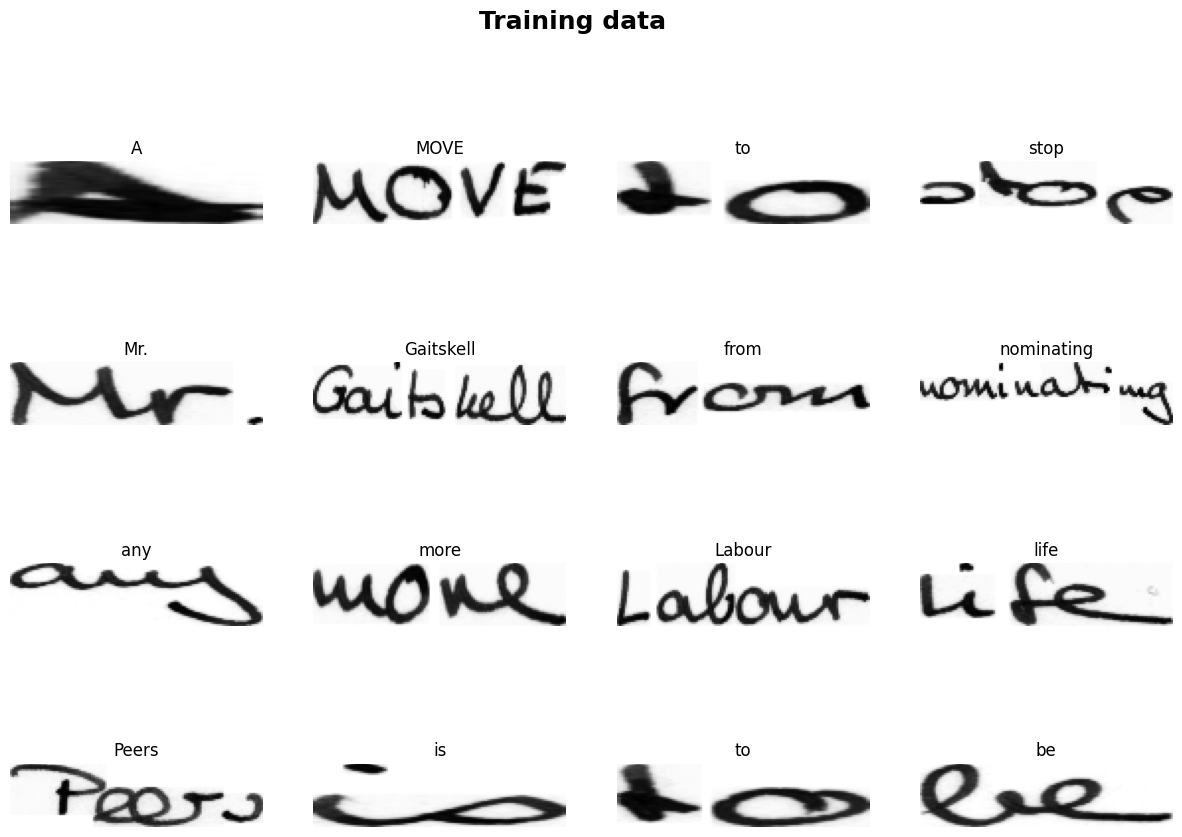

In [15]:

# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_list, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

train_data_fig, ax = plt.subplots(4, 4, figsize=(15, 10))
train_data_fig.suptitle('Training data', weight='bold', size=18)


for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]

    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i]+1)).numpy().decode("utf-8")

        label = label.replace('[UNK]', '')
        ax[i // 4, i % 4].imshow(img[:, :, 0], cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [16]:
## Ref: https://keras.io/examples/vision/captcha_ocr/

class CTCLayer(layers.Layer):

    def __init__(self, name=None):

        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [17]:
inputs = Input(shape=(32, 128, 1), name="image")

labels = layers.Input(name="label", shape=(None,), dtype="float32")

conv_1 = Conv2D(32, (3,3), activation = "selu", padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)

conv_2 = Conv2D(64, (3,3), activation = "selu", padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

conv_3 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_2)
conv_4 = Conv2D(128, (3,3), activation = "selu", padding='same')(conv_3)

conv_5 = Conv2D(512, (3,3), activation = "selu", padding='same')(conv_4)
conv_6 = Conv2D(512, (3,3), activation = "selu", padding='same')(conv_5)
drop_out=tf.keras.layers.Dropout(0.2)(conv_6)
conv_7 = Conv2D(512, (3,3), activation = "selu", padding='same')(drop_out)
conv_8 = Conv2D(512, (3,3), activation = "selu", padding='same')(conv_7)

pool_4 = MaxPool2D(pool_size=(2, 1))(conv_8)

conv_5 = Conv2D(256, (3,3), activation = "selu", padding='same')(pool_4)

# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
conv_6 = Conv2D(256, (3,3), activation = "selu", padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
conv_7 = Conv2D(64, (2,2), activation = "selu")(pool_6)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
blstm_2 = Bidirectional(LSTM(512, return_sequences=True))(blstm_1)
blstm_3 = Bidirectional(LSTM(512, return_sequences=True))(blstm_2)
blstm_4 = Bidirectional(LSTM(512, return_sequences=True))(blstm_3)
blstm_5 = Bidirectional(LSTM(128, return_sequences=True))(blstm_4)
dense_=Dense(128,activation = 'relu', name="dense_1")(blstm_5)
softmax_output = Dense(len(char_list) + 1, activation = 'softmax', name="dense_2")(dense_)

output = CTCLayer(name="ctc_loss",)(labels, softmax_output)


optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

#model to be used at training time
model = Model(inputs=[inputs, labels], outputs=output)
model.compile(optimizer = optimizer,metrics=[tf.keras.metrics.Accuracy()])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 32, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 32, 128, 32)  320         ['image[0][0]']                  
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 64, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 64, 64)   18496       ['max_pooling2d[0][0]']      

c:\Users\johns\anaconda3\envs\machine-learning-conda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 32, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 32, 128, 32)  320         ['image[0][0]']                  
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 64, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 64, 64)   18496       ['max_pooling2d[0][0]']      

In [20]:
model.fit(train_dataset,
                        epochs = 100,
                        validation_data=validation_dataset,
                        verbose = 1,
                        shuffle=True)

Epoch 1/100
1724/1724 [==============================] - 200s 116ms/step - loss: 10.7445 - accuracy: 0.0000e+00 - val_loss: 10.7531 - val_accuracy: 0.0000e+00
Epoch 2/100
1724/1724 [==============================] - 199s 116ms/step - loss: 9.7338 - accuracy: 0.0000e+00 - val_loss: 9.3825 - val_accuracy: 0.0000e+00
Epoch 3/100
1724/1724 [==============================] - 178s 103ms/step - loss: 8.7847 - accuracy: 0.0000e+00 - val_loss: 8.7083 - val_accuracy: 0.0000e+00
Epoch 4/100
1724/1724 [==============================] - 168s 97ms/step - loss: 7.9721 - accuracy: 0.0000e+00 - val_loss: 8.6301 - val_accuracy: 0.0000e+00
Epoch 5/100
1724/1724 [==============================] - 164s 95ms/step - loss: 7.3382 - accuracy: 0.0000e+00 - val_loss: 7.6754 - val_accuracy: 0.0000e+00
Epoch 6/100
1724/1724 [==============================] - 164s 95ms/step - loss: 6.7589 - accuracy: 0.0000e+00 - val_loss: 8.4228 - val_accuracy: 0.0000e+00
Epoch 7/100
1724/1724 [==============================] - 16

In [24]:
model.save("model.keras")

PermissionError: [Errno 13] Unable to synchronously create file (unable to open file: name = 'model.keras', errno = 13, error message = 'Permission denied', flags = 13, o_flags = 302)

In [25]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense_2").output
)
prediction_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 128)        7385

In [26]:
def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []

    pred_indcies = np.argmax(predictions, axis=2)

    for i in range(pred_indcies.shape[0]):
        ans = ""

        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indcies[i])]

        ## remove blanks
        for p in merged_list:
            if p != len(char_list):
                ans += char_list[int(p)]

        text_list.append(ans)

    return text_list

1/1 [==============================] - 0s 41ms/step


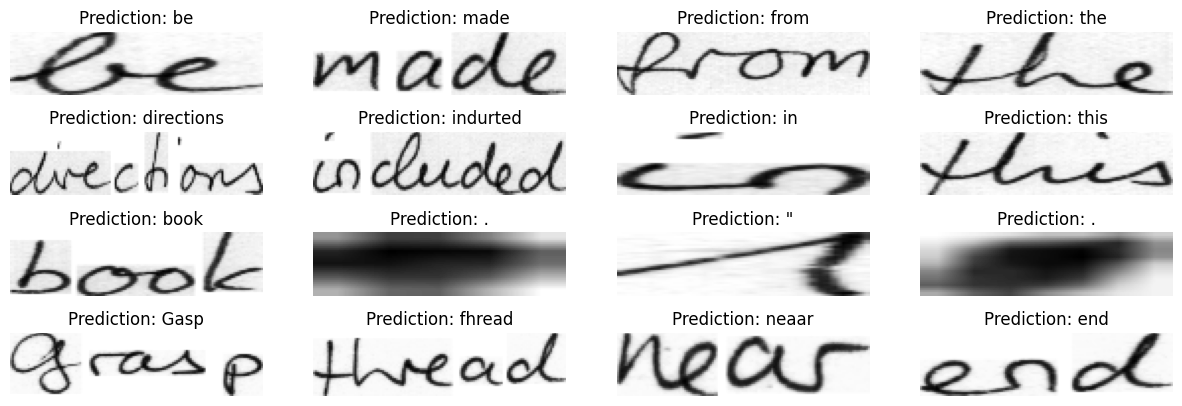

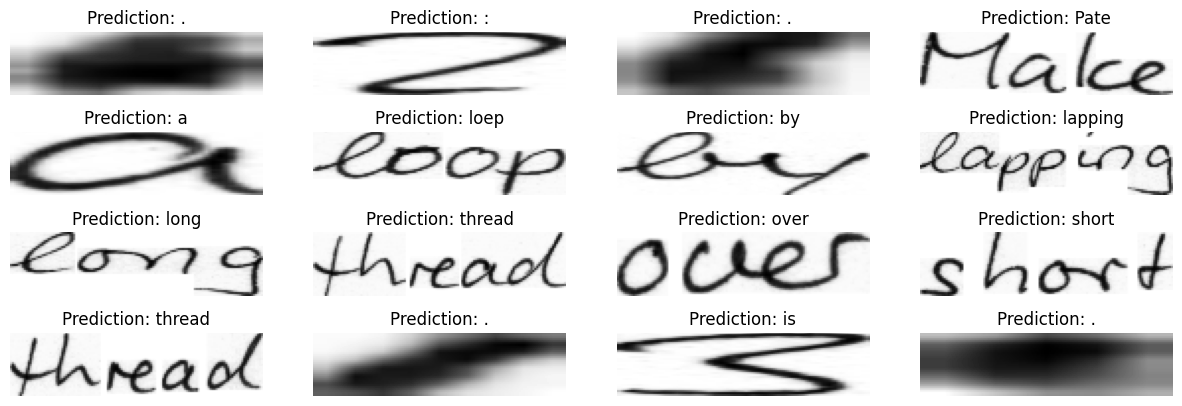

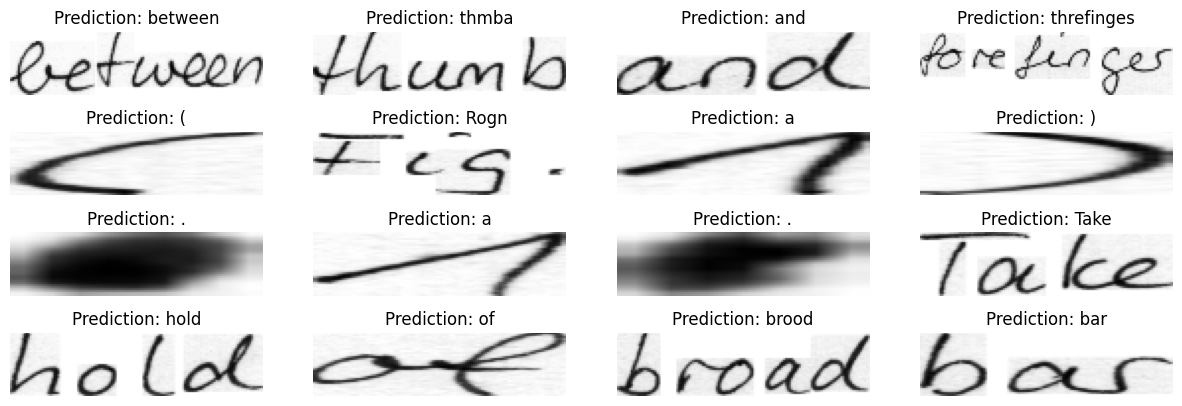

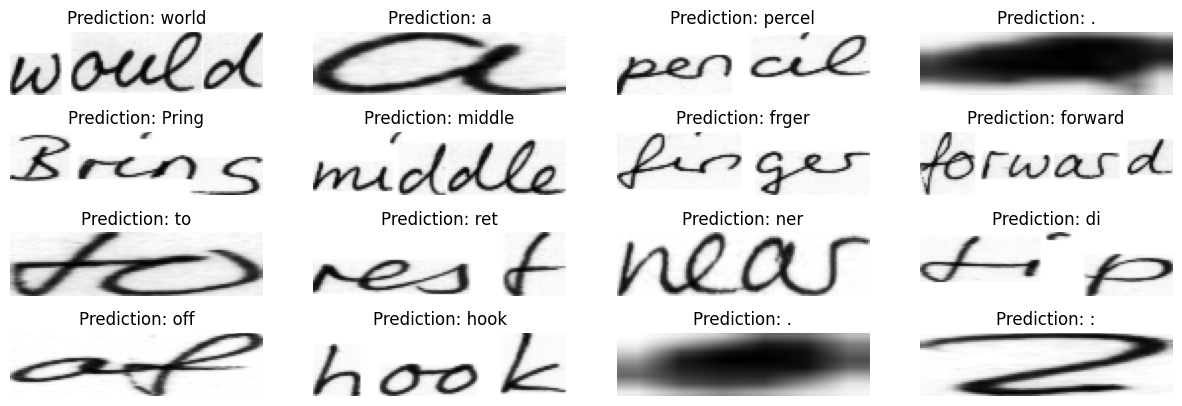

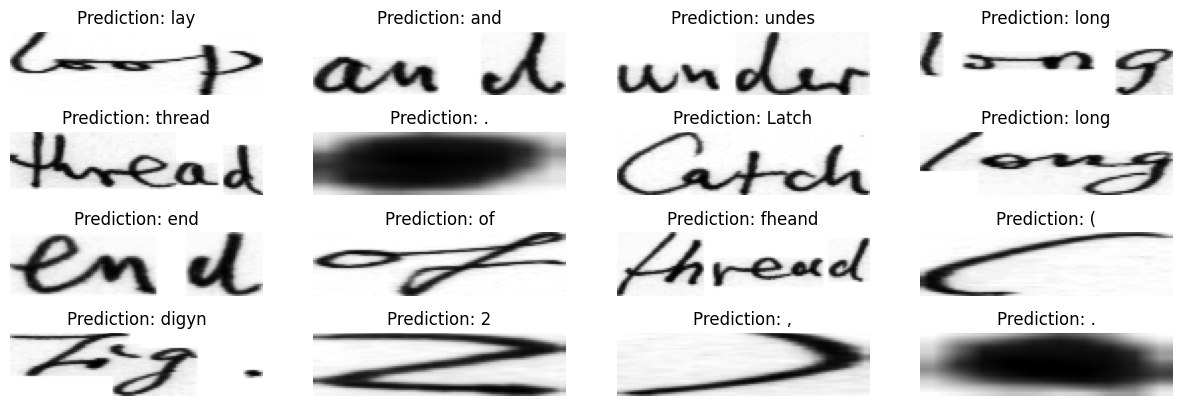

In [27]:
#  Let's check results on some validation samples
for batch in validation_dataset.take(5):

    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = ctc_decoder(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    fig , ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(16):

        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()